In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных

In [2]:
ds = pd.read_csv('data/housing.csv')
print(ds.shape)
ds.head()

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# 1. Масштабирование

а. Нормализовать признак - median_income

In [3]:
f = 'median_income'

In [4]:
ds[f+'_norm'] = (ds[f]-ds[f].mean())/ds[f].std()

/home/egor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


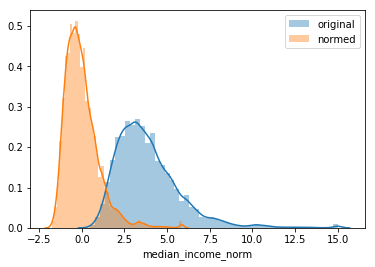

In [5]:
sns.distplot(ds[f], label='original')
sns.distplot(ds[f+'_norm'], label='normed')
plt.legend()
plt.show()

б. Привести признак - population к масштабу от 0 до 100

In [6]:
f = 'population'

In [7]:
ds[f+'_scaled'] = (ds[f]-ds[f].min())/(ds[f].max()-ds[f].min())*100

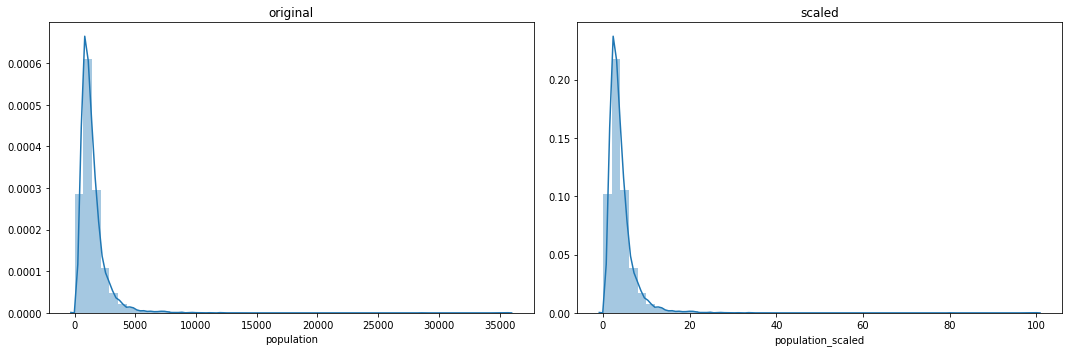

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(ds[f])
plt.title('original')

plt.subplot(122)
sns.distplot(ds[f+'_scaled'])
plt.title('scaled')

plt.tight_layout()
plt.show()

# 2. Заполнение пропусков:

а. Заполнить пропуски в столбце total_bedrooms средними значениями по категориям столбца ocean_proximity
Например, если пропущенно значение в строке с категорией INLAND, нужно заполнить его средним значением по этой категории

In [9]:
mean_beds = ds.groupby('ocean_proximity')['total_bedrooms'].mean().to_dict()
na_flags = ds['total_bedrooms'].isna()

In [10]:
ds.loc[na_flags, 'total_bedrooms'] = ds.loc[na_flags, 'ocean_proximity'].apply(lambda x: mean_beds[x])

In [11]:
ds.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
median_income_norm    0
population_scaled     0
dtype: int64

# 3. Категорийные атрибуты:

а. Посчитать среднее кол-во комнат в строке (total_rooms/households)

In [12]:
ds['mean_rooms'] = ds['total_rooms']/ds['households']

б. Разбить полученный столбец на группы на ваше усмотрение (Например, 1 комната, 2 комнаты, 3 и более комнат)

Text(0.5, 1.0, 'log scale')

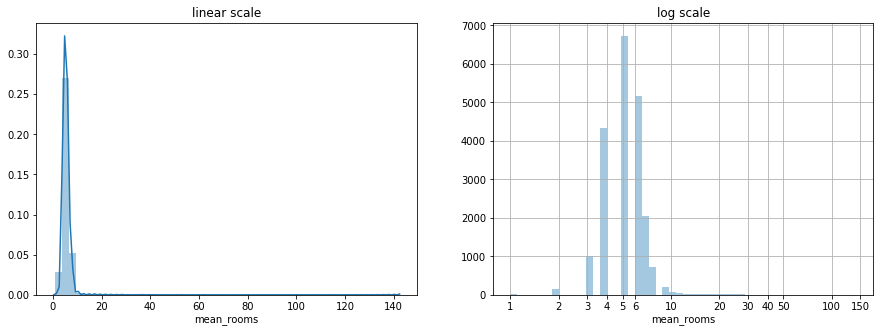

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(ds['mean_rooms'])
plt.title('linear scale')

plt.subplot(122)
sns.distplot(np.log(ds['mean_rooms'].round(0)), kde=False)
xlabels = list(range(1,7))+list(range(10,50,10))+list(range(50,151,50))
plt.xticks(np.log(xlabels), xlabels)
plt.grid()
plt.title('log scale')

Разобьём кол-во комнат на группы в зависимости от доли их встречаемости в датасете

In [14]:
bins = np.array([0,4,5,6,7,200])
np.histogram(ds['mean_rooms'].round(0), bins=bins,)

(array([1180, 4333, 6728, 5166, 3233]), array([  0,   4,   5,   6,   7, 200]))

In [15]:
ds['mean_rooms_grouped'] = ds['mean_rooms'].round(0).apply(lambda x: (x<bins).argmax())

In [16]:
d = {1: '3-', 2:'4', 3:'5',4:'6',5:'7+'}
ds['mean_rooms_grouped_verb'] = ds['mean_rooms_grouped'].apply(lambda x: d[x])

<BarContainer object of 5 artists>

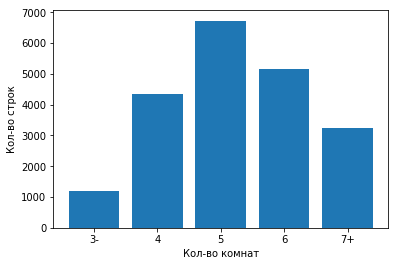

In [17]:
s = ds['mean_rooms_grouped_verb'].value_counts().sort_index()
plt.xlabel('Кол-во комнат')
plt.ylabel('Кол-во строк')
plt.bar(s.index ,s.values)